You can choose to upload the Kaggle API token to download the data, download it manually and upload it to this Colab instance, or simply download it from a Google Drive link using gdown, you can choose to run either one.

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving test.csv.zip to test.csv.zip
Saving train.csv.zip to train.csv.zip


In [ ]:
!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle competitions download -c fake-news

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip test.csv.zip
!unzip train.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# download from Google Drive
!gdown "https://drive.google.com/uc?id=178f_VkNxccNidap-5-uffXUW475pAuPy&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=178f_VkNxccNidap-5-uffXUW475pAuPy&confirm=t
To: /content/fake-news.zip
100% 48.7M/48.7M [00:00<00:00, 55.9MB/s]


In [ ]:
!unzip fake-news.zip

Archive:  fake-news.zip
  inflating: submit.csv              
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
### Import all library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# load the dataset
news_d = pd.read_csv("Constraint_Train.csv")
submit_test = pd.read_csv("Constraint_Test.csv")

In [ ]:
news_d['label'] = news_d['label'].replace(['real','fake'],[1,0])
# submit_test['label'] = submit_test['label'].replace(['real','fake'],[1,0])

In [ ]:
## Shape and colums of train dataset
print(" Shape of News data :: ", news_d.shape)
print(" News data columns", news_d.columns)

 Shape of News data ::  (6420, 3)
 News data columns Index(['id', 'tweet', 'label'], dtype='object')


In [ ]:
## by using df.head(),We can immediately familiarize ourselves with the dataset. 
news_d.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,1
1,2,States reported 1121 deaths a small rise from ...,1
2,3,Politically Correct Woman (Almost) Uses Pandem...,0
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,1
4,5,Populous states can generate large case counts...,1


In [ ]:
#Text Word startistics: min.mean, max and interquartile range

txt_length = news_d.tweet.str.split().str.len()
txt_length.describe()

count    6420.000000
mean       27.000156
std        24.577676
min         3.000000
25%        15.000000
50%        25.000000
75%        37.000000
max      1456.000000
Name: tweet, dtype: float64

In [ ]:
# #Title statistics 

# title_length = news_d.title.str.split().str.len()
# title_length.describe()

1: Unreliable
0: Reliable
Distribution of labels:
1    3360
0    3060
Name: label, dtype: int64


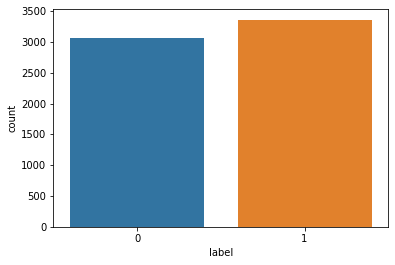

In [ ]:
sns.countplot(x="label", data=news_d);
print("1: Unreliable")
print("0: Reliable")
print("Distribution of labels:")
print(news_d.label.value_counts());


In [ ]:
print(round(news_d.label.value_counts(normalize=True),2)*100);

1    52.0
0    48.0
Name: label, dtype: float64


In [ ]:
# Constants that are used to sanitize the datasets 
column_n = ['id',  'tweet', 'label']
remove_c = ['id']
categorical_features = []
target_col = ['label']
text_f = [ 'tweet']

In [ ]:
# Clean Datasets
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
from collections import Counter

ps = PorterStemmer()
wnl = nltk.stem.WordNetLemmatizer()

stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

# Removed unused clumns
def remove_unused_c(df,column_n=remove_c):
    df = df.drop(column_n,axis=1)
    return df

# Impute null values with None
def null_process(feature_df):
    for col in text_f:
        feature_df.loc[feature_df[col].isnull(), col] = "None"
    return feature_df

def clean_dataset(df):
    # remove unused column
    df = remove_unused_c(df)
    #impute null values
    df = null_process(df)
    return df

# Cleaning text from unused characters
def clean_text(text):
    text = str(text).replace(r'http[\w:/\.]+', ' ')  # removing urls
    text = str(text).replace(r'[^\.\w\s]', ' ')  # remove everything but characters and punctuation
    text = str(text).replace('[^a-zA-Z]', ' ')
    text = str(text).replace(r'\s\s+', ' ')
    text = text.lower().strip()
    #text = ' '.join(text)    
    return text

## Nltk Preprocessing include:
# Stop words, Stemming and Lemmetization
# For our project we use only Stop word removal
def nltk_preprocess(text):
    text = clean_text(text)
    wordlist = re.sub(r'[^\w\s]', '', text).split()
    #text = ' '.join([word for word in wordlist if word not in stopwords_dict])
    #text = [ps.stem(word) for word in wordlist if not word in stopwords_dict]
    text = ' '.join([wnl.lemmatize(word) for word in wordlist if word not in stopwords_dict])
    return  text

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# Perform data cleaning on train and test dataset by calling clean_dataset function
df = clean_dataset(news_d)
# apply preprocessing on text through apply method by calling the function nltk_preprocess
df["tweet"] = df.tweet.apply(nltk_preprocess)
# apply preprocessing on title through apply method by calling the function nltk_preprocess
# df["title"] = df.title.apply(nltk_preprocess)

In [ ]:
# Dataset after cleaning and preprocessing step
df.head()

,tweet,label
0,cdc currently report 99031 death general discr...,1
1,state reported 1121 death small rise last tues...,1
2,politically correct woman almost us pandemic e...,0
3,indiafightscorona 1524 covid testing laborator...,1
4,populous state generate large case count look ...,1


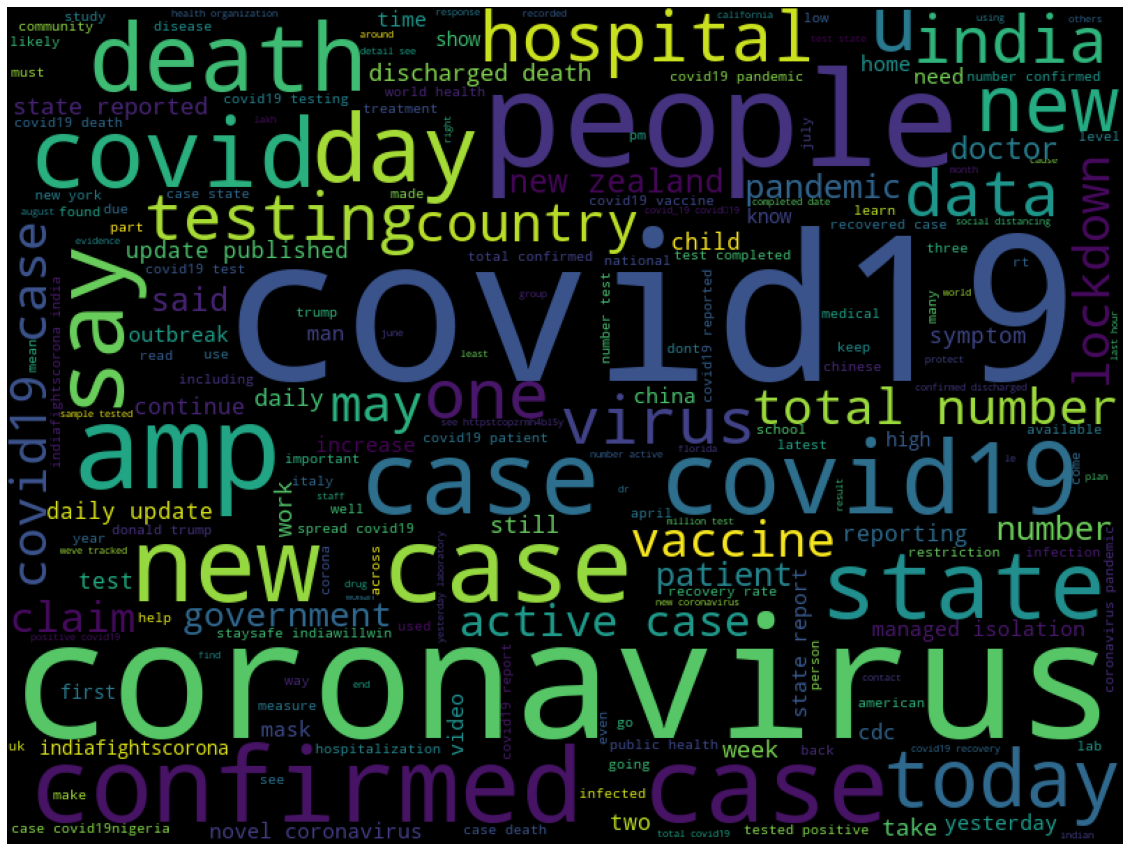

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# initialize the word cloud
wordcloud = WordCloud( background_color='black', width=800, height=600)
# generate the word cloud by passing the corpus
text_cloud = wordcloud.generate(' '.join(df['tweet']))
# plotting the word cloud
plt.figure(figsize=(20,30))
plt.imshow(text_cloud)
plt.axis('off')
plt.show()

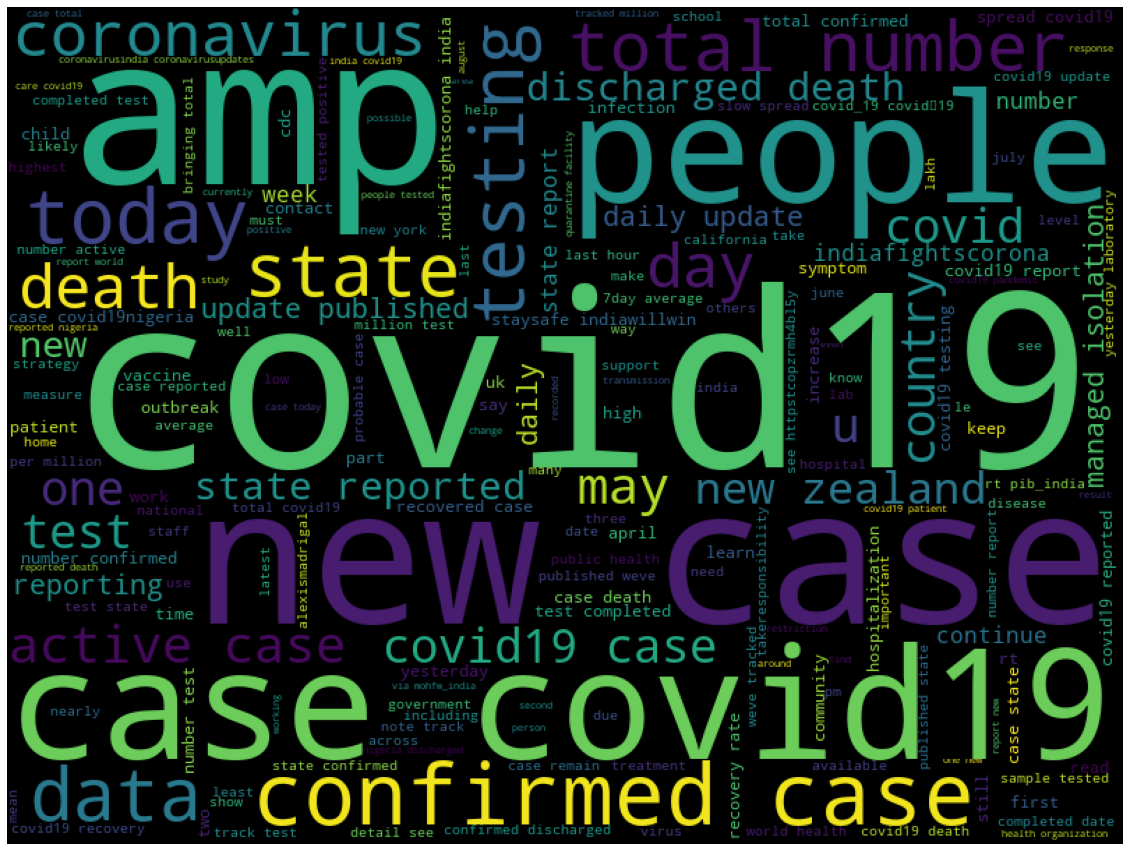

In [ ]:
true_n = ' '.join(df[df['label']==1]['tweet']) 
wc = wordcloud.generate(true_n)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.show()

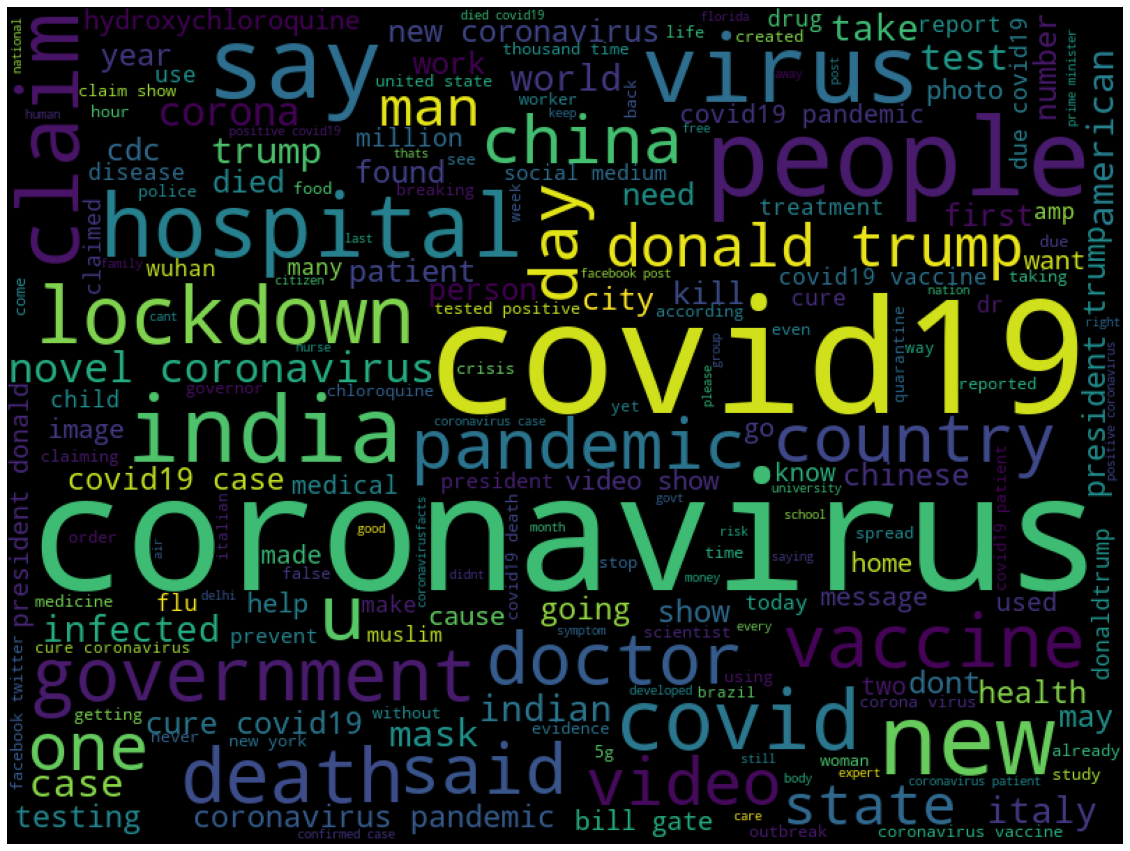

In [ ]:
fake_n = ' '.join(df[df['label']==0]['tweet'])
wc= wordcloud.generate(fake_n)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [ ]:
def plot_top_ngrams(corpus, title, ylabel, xlabel="Number of Occurences", n=2):
  """Utility function to plot top n-grams"""
  true_b = (pd.Series(nltk.ngrams(corpus.split(), n)).value_counts())[:20]
  true_b.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.show()

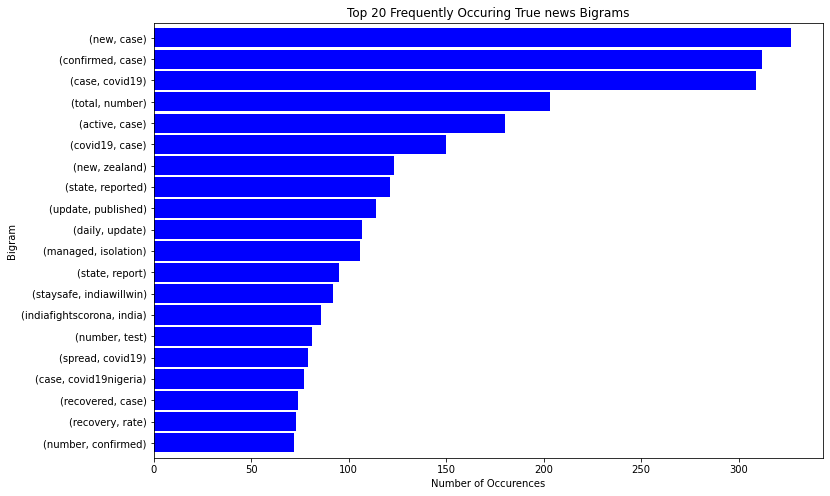

In [ ]:
plot_top_ngrams(true_n, 'Top 20 Frequently Occuring True news Bigrams', "Bigram", n=2)

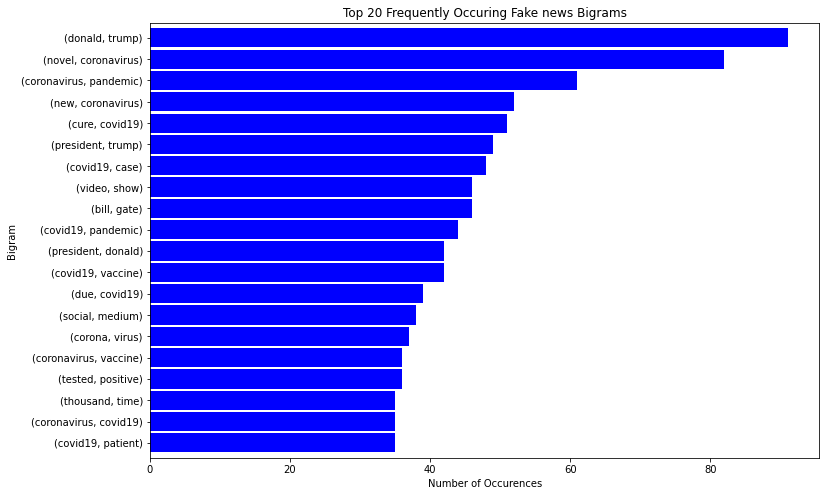

In [ ]:
plot_top_ngrams(fake_n, 'Top 20 Frequently Occuring Fake news Bigrams', "Bigram", n=2)

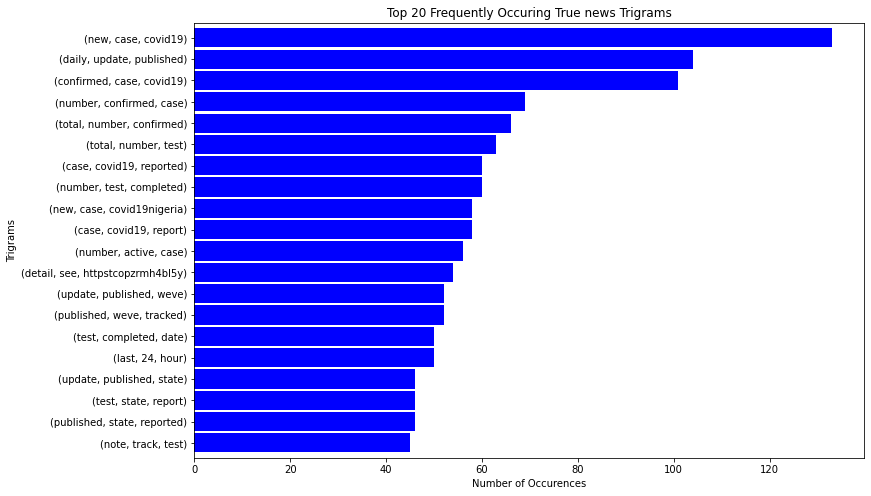

In [ ]:
plot_top_ngrams(true_n, 'Top 20 Frequently Occuring True news Trigrams', "Trigrams", n=3)

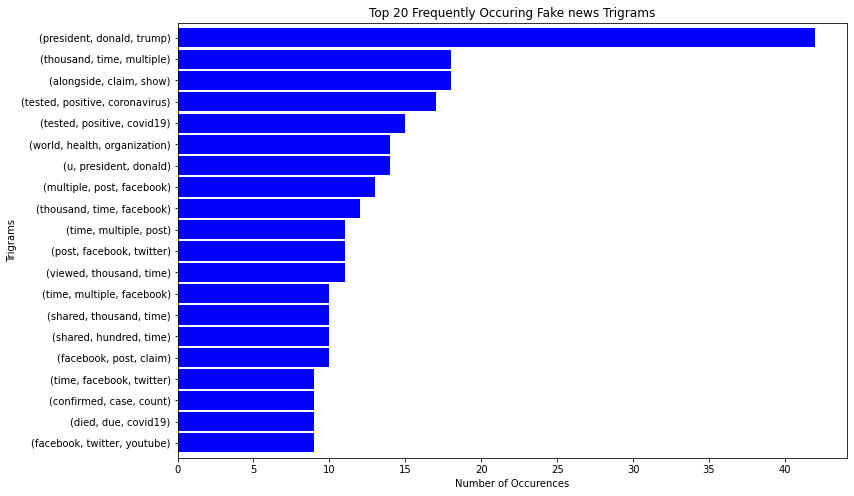

In [ ]:
plot_top_ngrams(fake_n, 'Top 20 Frequently Occuring Fake news Trigrams', "Trigrams", n=3)

# Fine-tuning BERT

In [ ]:
!pip install transformers

In [ ]:
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
from sklearn.model_selection import train_test_split

import random

In [ ]:
def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)

set_seed(1)

In [ ]:
# the model we gonna train, base uncased BERT
model_name = "bert-base-uncased"
# max sequence length for each document/sentence sample
max_length = 512

In [ ]:
# load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_ac

In [ ]:
news_df = news_d[news_d['tweet'].notna()]
# news_df = news_df[news_df["author"].notna()]
# news_df = news_df[news_df["title"].notna()]

In [ ]:
def prepare_data(df, test_size=0.2, include_title=True, include_author=True):
  texts = []
  labels = []
  for i in range(len(df)):
    tweet = df["tweet"].iloc[i]
    label = df["label"].iloc[i]
    # if include_title:
    #   text = df["title"].iloc[i] + " - " + text
    # if include_author:
    #   text = df["author"].iloc[i] + " : " + text
    if tweet and label in [1, 0]:
      texts.append(tweet)
      labels.append(label)
  return train_test_split(texts, labels, test_size=test_size)

train_texts, valid_texts, train_labels, valid_labels = prepare_data(news_df)

In [ ]:
print(len(train_texts), len(train_labels))
print(len(valid_texts), len(valid_labels))

5136 5136
1284 1284


In [ ]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length`
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

In [ ]:
class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = NewsGroupsDataset(train_encodings, train_labels)
valid_dataset = NewsGroupsDataset(valid_encodings, valid_labels)

In [ ]:
# load the model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/pytorch_model.bin
Some weights of the model check

In [ ]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=10,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=200,               # log & save weights each logging_steps
    save_steps=200,
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

using `logging_steps` to initialize `eval_steps` to 200
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [ ]:
# train the model
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5136
  Num Epochs = 1
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 514


Step,Training Loss,Validation Loss,Accuracy
200,0.331800,0.213310,0.938474
400,0.188100,0.102389,0.972741


***** Running Evaluation *****
  Num examples = 1284
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1284
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-400
Configuration saved in ./results/checkpoint-400/config.json
Model weights saved in ./results/checkpoint-400/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-400 (score: 0.10238892585039139).


TrainOutput(global_step=514, training_loss=0.2301354983437386, metrics={'train_runtime': 510.0236, 'train_samples_per_second': 10.07, 'train_steps_per_second': 1.008, 'total_flos': 1351338380328960.0, 'train_loss': 0.2301354983437386, 'epoch': 1.0})

In [ ]:
# evaluate the current model after training
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1284
  Batch size = 20


{'eval_loss': 0.10238892585039139,
 'eval_accuracy': 0.9727414330218068,
 'eval_runtime': 9.5245,
 'eval_samples_per_second': 134.81,
 'eval_steps_per_second': 6.825,
 'epoch': 1.0}

In [ ]:
# saving the fine tuned model & tokenizer
model_path = "Covid Dataset Anal BERT Model: Trained"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Configuration saved in Covid Dataset Anal BERT Model: Trained/config.json
Model weights saved in Covid Dataset Anal BERT Model: Trained/pytorch_model.bin
tokenizer config file saved in Covid Dataset Anal BERT Model: Trained/tokenizer_config.json
Special tokens file saved in Covid Dataset Anal BERT Model: Trained/special_tokens_map.json


('Covid Dataset Anal BERT Model: Trained/tokenizer_config.json',
 'Covid Dataset Anal BERT Model: Trained/special_tokens_map.json',
 'Covid Dataset Anal BERT Model: Trained/vocab.txt',
 'Covid Dataset Anal BERT Model: Trained/added_tokens.json',
 'Covid Dataset Anal BERT Model: Trained/tokenizer.json')

In [ ]:
def get_prediction(text, convert_to_label=False):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    d = {
        0: "real",
        1: "fake"
    }
    if convert_to_label:
      return d[int(probs.argmax())]
    else:
      return int(probs.argmax())

In [ ]:
real_news = """
alfalfa is the only cure for covid 19
"""

In [ ]:
get_prediction(real_news, convert_to_label=True)

'reliable'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# read the test set
test_df = pd.read_csv("Constraint_Test.csv")

In [ ]:
test_df.head()

,id,tweet
0,1,Our daily update is published. States reported...
1,2,Alfalfa is the only cure for COVID-19.
2,3,President Trump Asked What He Would Do If He W...
3,4,States reported 630 deaths. We are still seein...
4,5,This is the sixth time a global health emergen...


In [ ]:
# make a copy of the testing set
new_df = test_df.copy()

In [ ]:
# add a new column that contains the author, title and article content
new_df["new_text"] = new_df["tweet"].astype(str)
new_df.head()

,id,tweet,new_text
0,1,Our daily update is published. States reported...,Our daily update is published. States reported...
1,2,Alfalfa is the only cure for COVID-19.,Alfalfa is the only cure for COVID-19.
2,3,President Trump Asked What He Would Do If He W...,President Trump Asked What He Would Do If He W...
3,4,States reported 630 deaths. We are still seein...,States reported 630 deaths. We are still seein...
4,5,This is the sixth time a global health emergen...,This is the sixth time a global health emergen...


In [ ]:
# get the prediction of all the test set
new_df["label"] = new_df["new_text"].apply(get_prediction)

In [ ]:
# make the submission file
final_df = new_df[["id","tweet", "label"]]
final_df.to_csv("submit_final.csv", index=False)

In [ ]:
!zip -r /content/model_savedile.zip /content/fake-news-bert-base-uncased

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')